# 1. 语义分割

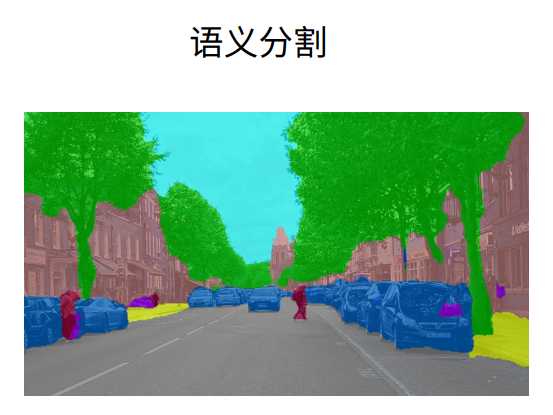

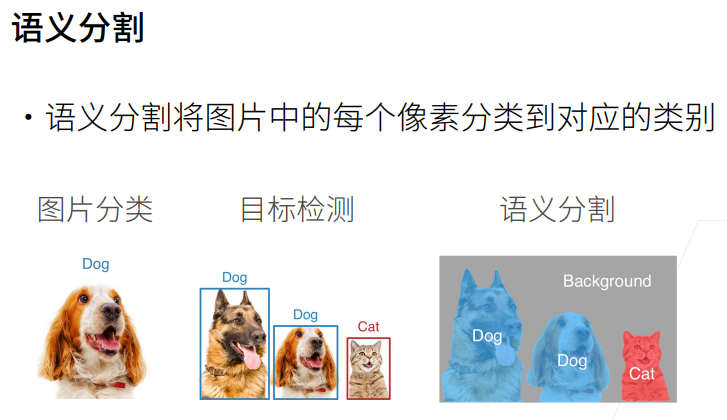

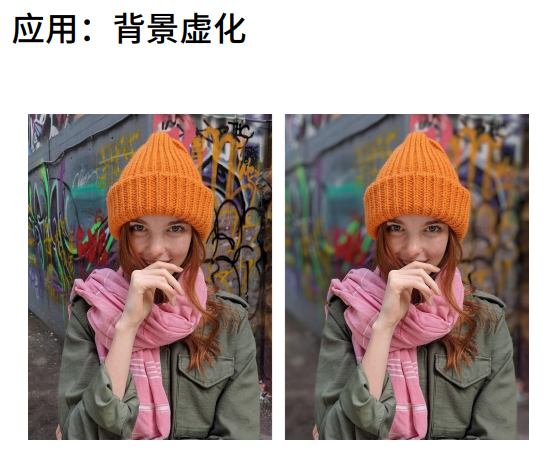

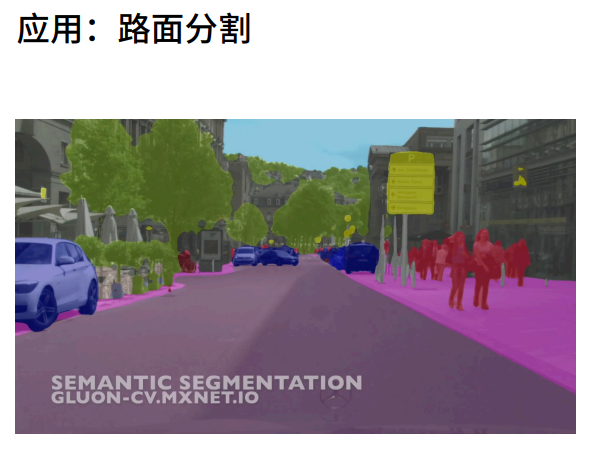

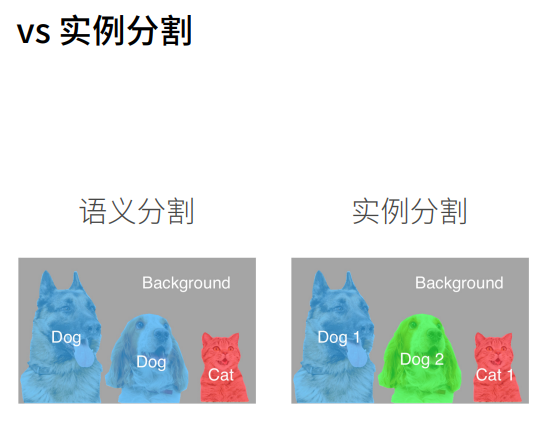

# 2. 语义分割

① 最重要的语义分割数据集之一是http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
#                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

# voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')

In [2]:
# 定义函数read_voc_images，用于读取VOC图像和标签。voc_dir是数据集的路径，is_train是一个布尔值，指示我们是读取训练集(True)还是验证集(False)
import os
import torchvision
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    # 定义txt_fname，这是我们将读取的文件的路径。如果is_train为True，我们读取的是'train.txt'，否则是'val.txt'。这些文件中包含了我们需要读取的图像的文件名
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                            'train.txt' if is_train else 'val.txt')
    # 设定图像的读取模式为RGB
    mode = torchvision.io.image.ImageReadMode.RGB
    # 读取txt_fname文件，并将文件中的内容分割成一个个的文件名，然后存储在images列表中   
    with open(txt_fname,'r') as f:
        images = f.read().split()
    # 创建两个空列表，分别用于存储特征和标签
    features, labels = [],[]
    # 对于images中的每个文件名
    for i, fname in enumerate(images):
        # 使用torchvision.io.read_image读取对应的图像文件，然后添加到features列表中
        features.append(torchvision.io.read_image(os.path.join(voc_dir,'JPEGImages',f'{fname}.jpg')))  
        # 使用torchvision.io.read_image读取对应的标签图像文件，然后添加到labels列表中
        labels.append(torchvision.io.read_image(os.path.join(voc_dir,'SegmentationClass',f'{fname}.png'),mode))  
    # 返回特征和标签列表
    return features, labels

# 调用read_voc_images函数，读取训练数据集的图像和标签，然后存储在train_features和train_labels中
# print(voc_dir)
voc_dir = 'data/VOCdevkit/VOC2012'
train_features, train_labels = read_voc_images(voc_dir, True)


<class 'torch.Tensor'>


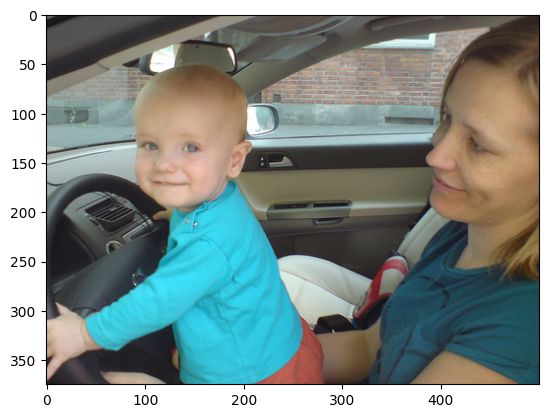

In [3]:
# len(train_features)
# d2l.show_images(train_features[0],2,1)
import matplotlib.pyplot as plt
import torch
import numpy as np
print(type(train_features[0]))
img_np = train_features[1463].numpy()
img_np = img_np.transpose(1, 2, 0)
plt.imshow(img_np)




torch.Size([3, 337, 500])
torch.Size([337, 500, 3])


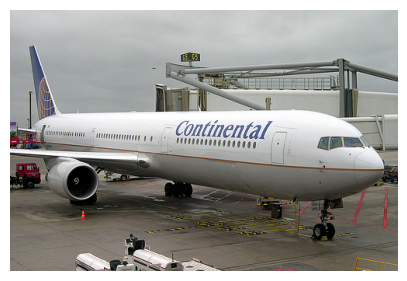

In [4]:
#这里是给MAE进行处理
imagenet_mean = torch.tensor([[0.485, 0.456, 0.406]])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])
img = train_features[1400]
print(img.shape)
img = img.permute(1,2,0)
img = img/255

img = img - imagenet_mean
img = img / imagenet_std



def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
plt.rcParams['figure.figsize'] = [5, 5]
show_image(img)
print(img.shape)

In [8]:
#数据增强
def voc_rand_crop(feature, label, height, width):
    """随即裁剪特征和标签图像"""
    # 调用RandomCrop的get_params方法，随机生成一个裁剪框。裁剪框的大小是(height, width)
    # rect拿到特征的框
    rect = torchvision.transforms.RandomCrop.get_params(feature,(height,width))   
    # 根据生成的裁剪框，对特征图像进行裁剪
    # 拿到框中的特征和标号
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 根据生成的裁剪框，对标签图像进行裁剪。注意，我们是在同一个裁剪框下裁剪特征图像和标签图像，以保证它们对应的位置仍然是对齐的
    label = torchvision.transforms.functional.crop(label,*rect)
    # 返回裁剪后的特征图像和标签图像
    return feature, label

img = img.permute(2,0,1)
print(img.shape)
feature = []
lable = []
for _ in range(4):
    # 调用上面定义的voc_rand_crop函数，对训练集中的第一个特征图像和标签图像进行随机裁剪，然后将裁剪后的图像添加到imgs列表中
    f_, l_ = voc_rand_crop(img,train_labels[1400],224,224)
    feature.append(f_.permute(1,2,0))
    lable.append(l_.permute(1,2,0))
    print(l_.shape)

# print(lable[0].shape)
# print(len(lable))
print(1)


torch.Size([500, 3, 337])


ValueError: Required crop size (224, 224) is larger than input image size (3, 337)

[tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8), tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 

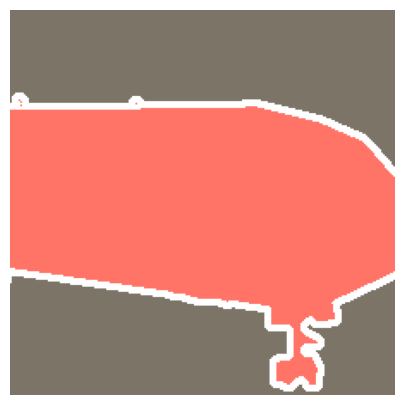

In [7]:
show_image(feature[1])
show_image(lable[1])
print(lable)
print(lable[0].shape)

In [3]:
# 绘制前5个输入图像及其标签
# 设置要展示的图像的数量，这里是5
n = 5
# 创建一个新的列表，该列表包含前5个图像特征和对应的标签图像
imgs = train_features[0:n] + train_labels[0:n] # 读的时候channel是在前面
# 将列表中的每个图像的通道维度从第一维（0开始计数）移到最后一维，因为matplotlib等绘图库需要将通道维度放在最后才能正常显示图像
imgs = [img.permute(1,2,0) for img in imgs] # 画的时候把channel放到后面
# 使用d2l库的show_images函数显示图像，这里第一个参数是图像列表，第二个参数是行数（这里是2行，分别对应图像和标签），第三个参数是每行的图像数量（这里是n，即5）
# d2l.show_images(imgs,2,n) # 第一行显示的是图片，第二行显示的是标号

In [4]:
# 列举RGB颜色值和类名
# 每一种RGB颜色对应的标号
# 定义VOC_COLORMAP，这是一个列表，包含了PASCAL VOC数据集中每种类别的RGB颜色值。每种类别在标签图像中由一种特定的颜色表示，颜色的RGB值就是这里定义的。
VOC_COLORMAP = [[0,0,0],[128,0,0],[0,128,0],[128,128,0],
               [0,0,128],[128,0,128],[0,128,128],[128,128,128],
               [64,0,0],[192,0,0],[64,128,0],[192,128,0],
               [64,0,128],[192,0,128],[64,128,128],[192,128,128],
               [0,64,0],[128,64,0],[0,192,0],[128,192,0],
               [0,64,128]]

# 定义VOC_CLASSES，这是一个列表，包含了PASCAL VOC数据集中每种类别的名字。列表中的类别名顺序与VOC_COLORMAP中的颜色值顺序相对应。
VOC_CLASSES = ['background','aeroplane','bicycle','bird','boat','bottle','bus',
              'car','cat','chair','cow','diningtable','dog','horse','motorbike',
              'person','potted plant','sheep','sofa','train','tv/monitor']   

In [5]:
# 查找标签中每个像素的类索引
# 定义函数voc_colormap2label，这个函数用于建立一个映射，将RGB颜色值映射为对应的类别索引
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    # 创建一个全零的张量，大小为256的三次方，因为RGB颜色的每个通道有256种可能的值，所以总共有256^3种可能的颜色组合。数据类型设为long
    colormap2label = torch.zeros(256**3, dtype=torch.long)
    # 对于VOC_COLORMAP中的每个颜色值（colormap）
    for i, colormap in enumerate(VOC_COLORMAP):
        # 计算颜色值的一维索引，并将这个索引对应的位置设为i。这样，给定一个颜色值，我们就可以通过这个映射找到对应的类别索引
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i  
    # 返回映射
    return colormap2label

# 定义函数voc_label_indices，这个函数用于将一张标签图像中的每个像素的颜色值映射为对应的类别索引
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    # 将输入的colormap的通道维度移到最后一维，并将其转换为numpy数组，然后转换为int32类型。这是因为我们需要使用numpy的高级索引功能
    colormap = colormap.permute(1,2,0).numpy().astype('int32')
    # 计算colormap中每个像素的颜色值对应的一维索引。这里的索引计算方式和上一个函数中的是一致的
    idx = ((colormap[:,:,0] * 256 + colormap[:,:,1]) * 256 + colormap[:,:,2])  
    # 使用colormap2label这个映射将索引映射为对应的类别索引，并返回
    return colormap2label[idx]

In [9]:
# 例如
# 调用上面定义的两个函数，将训练数据集中的第一个标签图像的RGB颜色值转换为对应的类别索引，并将结果保存在变量y中
y = voc_label_indices(train_labels[0], voc_colormap2label())
print(y.shape)
# 打印变量y中的一小部分，即第105行到115行，第130列到140列的部分。这里是为了查看转换后的类别索引是否正确
print(y[105:115,130:140])
# 打印VOC_CLASSES列表中的第二个类别名（索引为1）。这里是为了查看第二个类别名是什么
print(VOC_CLASSES[1]) # 标签类别

torch.Size([281, 500])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])
aeroplane


torch.Size([3, 281, 500])
torch.Size([3, 224, 224])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

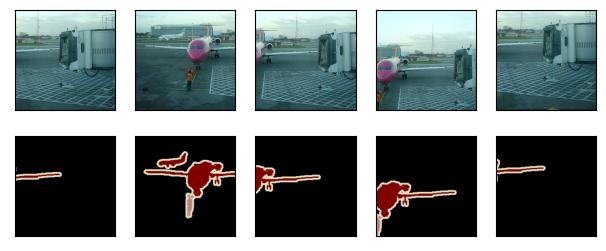

In [8]:
# 使用图像增广中的随即裁剪，裁剪输入图像和标签的相同区域
# 定义函数voc_rand_crop，用于对输入的特征图像和标签图像进行随机裁剪。height和width是裁剪的高度和宽度
from d2l import torch as d2l
def voc_rand_crop(feature, label, height, width):
    """随即裁剪特征和标签图像"""
    # 调用RandomCrop的get_params方法，随机生成一个裁剪框。裁剪框的大小是(height, width)
    # rect拿到特征的框
    rect = torchvision.transforms.RandomCrop.get_params(feature,(height,width))   
    # 根据生成的裁剪框，对特征图像进行裁剪
    # 拿到框中的特征和标号
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 根据生成的裁剪框，对标签图像进行裁剪。注意，我们是在同一个裁剪框下裁剪特征图像和标签图像，以保证它们对应的位置仍然是对齐的
    label = torchvision.transforms.functional.crop(label,*rect)
    # 返回裁剪后的特征图像和标签图像
    return feature, label

imgs = []
# 对于每个数字i，在0到n-1的范围内
for _ in range(n):
    # 调用上面定义的voc_rand_crop函数，对训练集中的第一个特征图像和标签图像进行随机裁剪，然后将裁剪后的图像添加到imgs列表中
    imgs += voc_rand_crop(train_features[0],train_labels[0],224,224)
# 将imgs中的每个图像的通道维度移到最后一维，以方便绘图        
print(train_features[0].shape)
print(imgs[0].shape)
imgs = [img.permute(1,2,0) for img in imgs]
# 使用d2l库的show_images函数展示图像。这里首先将imgs列表中的图像分为两部分，一部分是特征图像，一部分是标签图像。然后将这两部分拼接在一起，使得特征图像和标签图像能够按对应的顺序展示
d2l.show_images(imgs[::2] + imgs[1::2],2,n)

In [8]:
# 自定义语义分割数据集类
# 定义一个自定义的数据集类，用于加载VOC数据集。这个类继承了torch.utils.data.Dataset
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""
    # 初始化方法，输入参数：is_train表示是否是训练集，crop_size是裁剪后的图像尺寸，voc_dir是VOC数据集的路径
    def __init__(self, is_train, crop_size, voc_dir):
        # 定义一个归一化变换，用于对输入图像进行归一化。这里使用了ImageNet数据集的均值和标准差
        self.transform = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])    
        # 保存裁剪尺寸到self.crop_size
        self.crop_size = crop_size
        # 调用之前定义的read_voc_images函数，读取VOC数据集的特征图像和标签图像
        features, labels = read_voc_images(voc_dir, is_train = is_train)
        # 对读取到的特征图像进行筛选和归一化处理，并保存到self.features中
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]  
        # 对读取到的标签图像进行筛选处理，并保存到self.labels中
        self.labels = self.filter(labels)
        # 创建一个从颜色映射到类别索引的映射表，并保存到self.colormap2label中
        self.colormap2label = voc_colormap2label()
        # 打印出读取到的图像数量
        print('read ' + str(len(self.features)) + ' examples')
        
    # 定义一个方法，用于对输入图像进行归一化处理
    def normalize_image(self, img):
        # 将输入图像转换为浮点数类型，并调用归一化变换对其进行处理，最后返回处理后的图像
        return self.transform(img.float())
    
    # 定义一个方法，用于筛选符合要求的图像。筛选条件是图像的高度和宽度都大于等于裁剪尺寸
    def filter(self, imgs):
        # 返回筛选后的图像列表
        return [img 
                for img in imgs 
                if (img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1] ) ]
    
    # 每一次返回的样本做一次rand_crop
    # 定义一个方法，用于根据索引获取一个样本。这是一个实现Dataset接口所必须的方法
    def __getitem__(self, idx):
        # 调用之前定义的voc_rand_crop函数，对指定索引的特征图像和标签图像进行随机裁剪
        feature, label = voc_rand_crop(self.features[idx],self.labels[idx],*self.crop_size)   
        # 调用voc_label_indices函数，将裁剪后的标签图像转换为类别索引，并返回裁剪和转换后的特征图像和标签图像
        return (feature, voc_label_indices(label,self.colormap2label))
    
    # 定义一个方法，用于获取数据集的长度。这是一个实现Dataset接口所必须的方法
    def __len__(self):
        # 返回特征图像列表的长度，即数据集的长度
        return len(self.features)

In [9]:
# 读取数据集
# 定义裁剪尺寸，即将图像裁剪成320x480像素大小
crop_size = (224, 224)
# 创建训练数据集实例，输入参数分别为：True表示这是一个训练数据集，crop_size是裁剪尺寸，voc_dir是VOC数据集的路径
voc_train = VOCSegDataset(True, crop_size, voc_dir)
# 创建测试数据集实例，输入参数分别为：False表示这不是一个训练数据集，crop_size是裁剪尺寸，voc_dir是VOC数据集的路径
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1456 examples
read 1436 examples


In [10]:
# 定义批次大小，即每个批次包含的样本数量
batch_size = 64
# 创建一个数据加载器实例，输入参数分别为：voc_train是待加载的数据集，batch_size是批次大小，shuffle=True表示在每个迭代周期中随机打乱数据，drop_last=True表示如果最后一个批次的样本数量小于batch_size，则丢弃该批次，num_workers=0表示数据加载不使用额外的进程或线程
train_iter = torch.utils.data.DataLoader(voc_train,batch_size,shuffle=True,drop_last=True,
                                        num_workers=0)
# 对数据加载器进行迭代，每次迭代都返回一个批次的数据，其中X是特征，Y是标签
# x = 0
for X,Y in train_iter:
    # 打印特征的形状，它应该是一个四维张量，其形状为(batch_size, channels, height, width)
    print(X.shape)
    # 打印标签的形状，它应该是一个三维张量，其形状为(batch_size, height, width)，其中每个元素是一个像素的类别索引
    print(Y.shape)  # Y也为每一个像素对应的值
    # from d2l import torch as d2l
    # d2l.show_images(X[0],2,1)
    # d2l.show_images(Y[0].unsqueeze(0),2,1)
    
    # 只迭代一次，所以立即跳出循环
    # x += 1
    # print(x)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 224, 224])


In [11]:
# 整合所有组件
# 定义一个函数来加载VOC语义分割数据集，输入参数是批次大小和裁剪尺寸
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    # 下载并提取VOC2012数据集，获取数据集的路径
    voc_dir = d2l.download_extract('voc2012',os.path.join('VOCdevkit','VOC2012'))  
    # 获取数据加载器的工作进程数量
    num_workers = d2l.get_dataloader_workers()
    # 创建一个训练数据加载器实例，输入参数分别为：VOCSegDataset是待加载的数据集，batch_size是批次大小，shuffle=True表示在每个迭代周期中随机打乱数据，drop_last=True表示如果最后一个批次的样本数量小于batch_size，则丢弃该批次，num_workers是数据加载器的工作进程数量
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size,shuffle=True,
                                            drop_last = True, num_workers=num_workers)
    # 创建一个测试数据加载器实例，输入参数分别为：VOCSegDataset是待加载的数据集，batch_size是批次大小，drop_last=True表示如果最后一个批次的样本数量小于batch_size，则丢弃该批次，num_workers是数据加载器的工作进程数量
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voce_dir), batch_size, drop_last=True,
                                           num_workers=num_workers)
    # 返回训练数据加载器和测试数据加载器
    return train_iter, test_iter

: 

read 1456 examples
read 1436 examples
torch.Size([64, 3, 224, 224])
torch.Size([64, 224, 224])


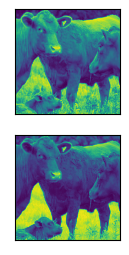

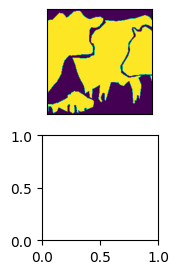

In [33]:
import test1 as Data_deal
image_size = (224, 224)
data_dir = "data/VOCdevkit/VOC2012"
train_iter, test_iter = Data_deal.load_data_voc(batch_size=64, crop_size = image_size, voc_dir=data_dir)
x = 1
for X,Y in train_iter:
# 打印特征的形状，它应该是一个四维张量，其形状为(batch_size, channels, height, width)
    print(X.shape)
    # 打印标签的形状，它应该是一个三维张量，其形状为(batch_size, height, width)，其中每个元素是一个像素的类别索引
    print(Y.shape)  # Y也为每一个像素对应的值
    from d2l import torch as d2l
    d2l.show_images(X[0],2,1)
    d2l.show_images(Y[0].unsqueeze(0),2,1)
    
    # 只迭代一次，所以立即跳出循环
    # x += 1
    # print(x)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64, 224, 224])


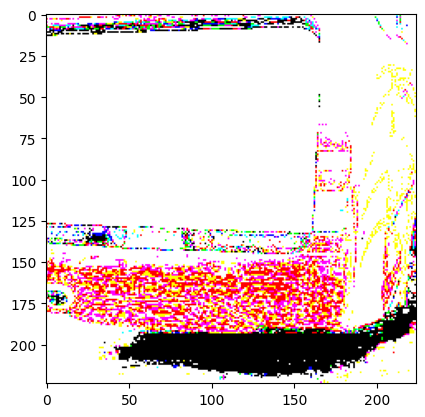

In [34]:

import matplotlib.pyplot as plt
import numpy as np
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


import matplotlib.pyplot as plt
import torch





def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
for X,Y in train_iter:
# 打印特征的形状，它应该是一个四维张量，其形状为(batch_size, channels, height, width)
    print(X.shape)
    # 打印标签的形状，它应该是一个三维张量，其形状为(batch_size, height, width)，其中每个元素是一个像素的类别索引
    print(Y.shape)  # Y也为每一个像素对应的值
    
    img_np = X[0].numpy()
    img_np = img_np.transpose(1, 2, 0)
    plt.imshow(img_np)



    break

In [13]:
help(d2l.get_dataloader_workers) # 默认数据加载器将使用4个进程来读取数据

Help on function get_dataloader_workers in module d2l.torch:

get_dataloader_workers()
    Use 4 processes to read the data.
    
    Defined in :numref:`sec_fashion_mnist`

